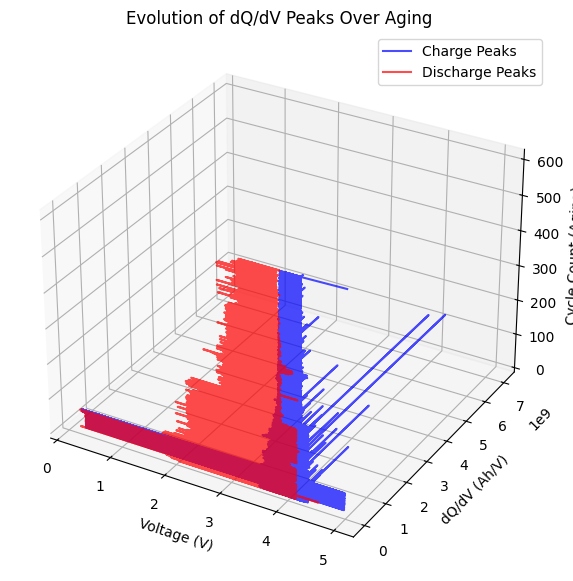

In [ ]:
# 3D Visualization of dQ/dV Peak Evolution Over Battery Aging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from mpl_toolkits.mplot3d import Axes3D

metadata_path = "../cleaned_dataset/metadata.csv"
data_dir = "../cleaned_dataset/data/"

metadata = pd.read_csv(metadata_path)
charge_meta = metadata[metadata["type"] == "charge"]
discharge_meta = metadata[metadata["type"] == "discharge"]

def compute_dQdV(voltage, capacity):
    dV = np.gradient(voltage)
    dQ = np.gradient(capacity)
    dQdV = np.divide(dQ, dV, out=np.zeros_like(dQ), where=dV!=0)
    return dQdV

charge_peaks, discharge_peaks = [], []
charge_cycles, discharge_cycles = [], []
charge_peak_voltages, discharge_peak_voltages = [], []

for idx, row in metadata.iterrows():
    if row["type"] not in ["charge", "discharge"]:
        continue
    file_path = os.path.join(data_dir, row["filename"])
    if not os.path.exists(file_path):
        continue
    cycle_data = pd.read_csv(file_path)
    voltage = cycle_data["Voltage_measured"].values
    time_diff = np.gradient(cycle_data["Time"].values)
    capacity = np.cumsum(cycle_data["Current_measured"].values * time_diff)
    dQdV = compute_dQdV(voltage, capacity)
    peaks, _ = find_peaks(dQdV, height=0)
    peak_voltages = voltage[peaks]
    peak_values = dQdV[peaks]
    if row["type"] == "charge":
        charge_peaks.append(peak_values)
        charge_peak_voltages.append(peak_voltages)
        charge_cycles.append(np.full_like(peak_values, row["test_id"]))
    else:
        discharge_peaks.append(peak_values)
        discharge_peak_voltages.append(peak_voltages)
        discharge_cycles.append(np.full_like(peak_values, row["test_id"]))

charge_peaks = np.concatenate(charge_peaks) if charge_peaks else np.array([])
discharge_peaks = np.concatenate(discharge_peaks) if discharge_peaks else np.array([])
charge_cycles = np.concatenate(charge_cycles) if charge_cycles else np.array([])
discharge_cycles = np.concatenate(discharge_cycles) if discharge_cycles else np.array([])
charge_peak_voltages = np.concatenate(charge_peak_voltages) if charge_peak_voltages else np.array([])
discharge_peak_voltages = np.concatenate(discharge_peak_voltages) if discharge_peak_voltages else np.array([])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sort_idx_charge = np.argsort(charge_cycles)
sort_idx_discharge = np.argsort(discharge_cycles)

ax.plot(charge_peak_voltages[sort_idx_charge], charge_peaks[sort_idx_charge], charge_cycles[sort_idx_charge], 
        color='blue', label="Charge Peaks", alpha=0.7)
ax.plot(discharge_peak_voltages[sort_idx_discharge], discharge_peaks[sort_idx_discharge], discharge_cycles[sort_idx_discharge], 
        color='red', label="Discharge Peaks", alpha=0.7)

ax.set_xlabel("Voltage (V)")
ax.set_ylabel("dQ/dV (Ah/V)")
ax.set_zlabel("Cycle Count (Aging)")
ax.set_title("Evolution of dQ/dV Peaks Over Aging")

plt.legend()
plt.show()